In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3)

import ksource_py as ks
import mcpl

In [2]:
plt.rcParams.update({'font.size': 14})

In [13]:
%matplotlib inline

# Generar muestras artificiales

In [39]:
N = int(1E5)

pt = "n"
su = 1
Es = np.exp(np.random.normal(-5, 1, (N,1)))
sx = sy = 10
poss = np.random.normal([0,0,0], [sx,sy,0], (N,3))
sdx = sdy = .1
dirs = np.random.normal([0,0,0], [sdx,sdy,0], (N,3))
dirs[:,2] = np.sqrt(1-dirs[:,0]**2-dirs[:,1]**2)
parts = np.concatenate((Es,poss,dirs), axis=1)
ws = np.random.normal(1, 0.1, N)

#!rm samples.ssv samples.mcpl.gz
tracksfile = "samples.ssv" # "tracks.ssv"
ks.savessv(pt, parts, ws, tracksfile)
mcplfile = ks.convert2mcpl(tracksfile, "ssv")

Converting ssv file to MCPL...
Done. Created samples.mcpl.gz


# Crear KSource

In [56]:
J = 1
set_params = True
plist = ks.PList(mcplfile, set_params=set_params)
geom = ks.Geometry([ks.Lethargy(), ks.SurfXY(), ks.Isotrop()])
s = ks.KSource(plist, geom, bw="silv", J=J)

Using existing file resampled.mcpl.gz
I = 100000.0
p2 = 100000.0
N = 100000


In [57]:
# Ajustar KSource

N = 1E4 # Cantidad de particulas a utilizar
s.bw_method = "silv" # silv, mlcv, knn
s.fit(N)

Usando 10000 particulas para ajuste
Calculando bw ... 
Hecho
Optimal bw (silv) = [[0.388 3.866 3.902 0.031 0.031 0.031]]


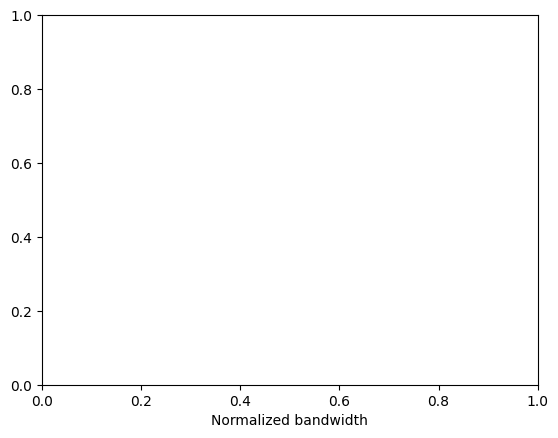

In [8]:
plt.xlabel("Normalized bandwidth")
#plt.savefig("score-eng.pdf")
plt.show()

In [2]:
# Cargar KSource previamente guardada

s = ks.KSource.load("samples_source.xml")
N = 1E4 # Cantidad de particulas a utilizar
s.fit(N)

Using existing file /home/inti/Documents/Maestria/KSource/examples/samples.mcpl.gz
I = 100028.89085501432
p2 = 101056.1314873632
N = 100000


# Evaluar estadistica

------------------------------------------------------------------------------
nparticles   : 100000
sum(weights) : 99950.4
------------------------------------------------------------------------------
             :            mean             rms             min             max
------------------------------------------------------------------------------
ekin   [MeV] :       0.0111259       0.0143158     5.29861e-05        0.326916
x       [cm] :       0.0445847         10.0179        -42.9512         47.6818
y       [cm] :      -0.0250151         10.0571        -42.2369         45.2694
z       [cm] :               0               0               0               0
ux           :     0.000112753       0.0998612       -0.436768        0.455628
uy           :     0.000183116        0.100207       -0.439247        0.425514
uz           :        0.989889       0.0102526        0.876404               1
time    [ms] :               0               0               0               0
weight 

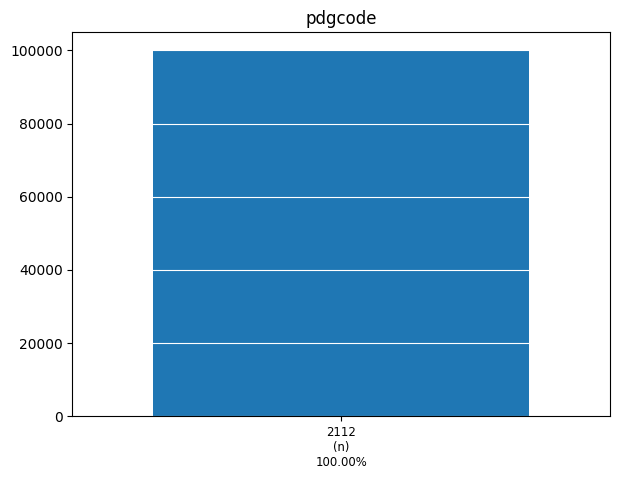

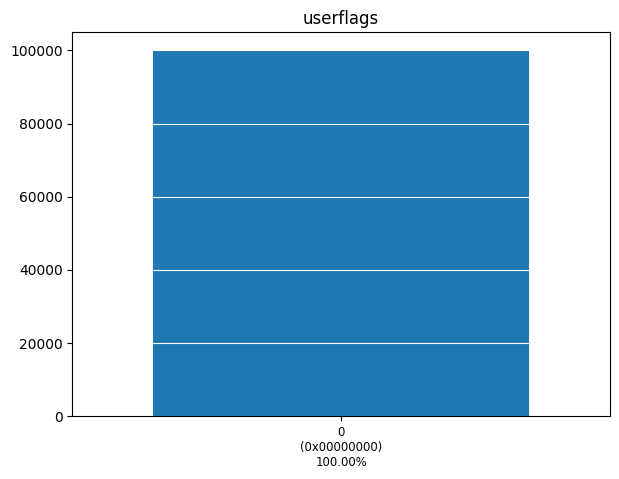

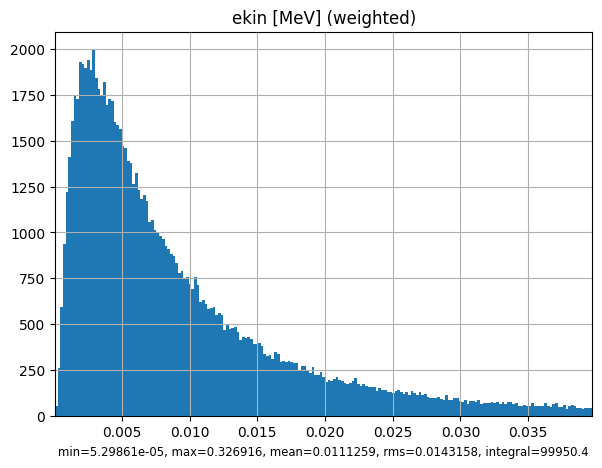

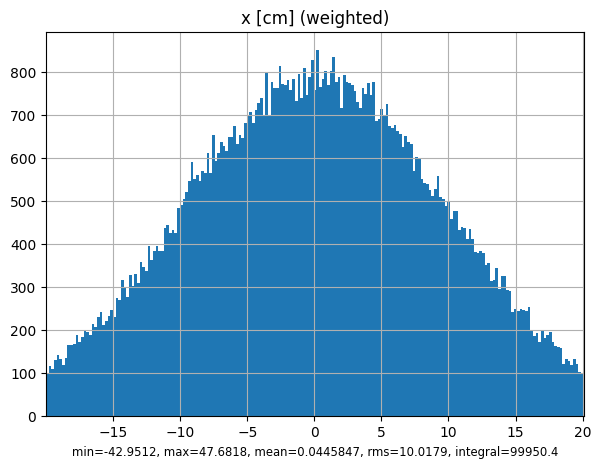

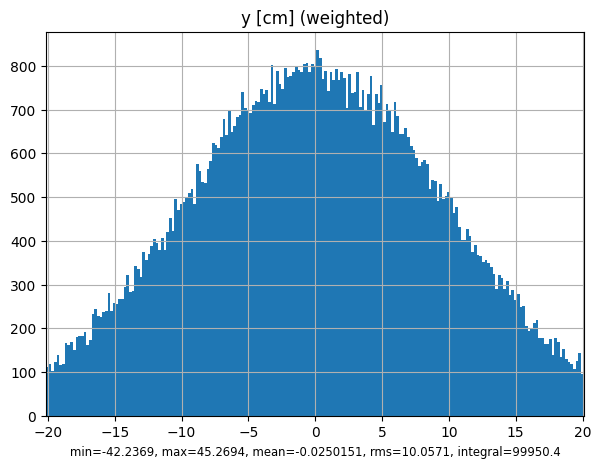

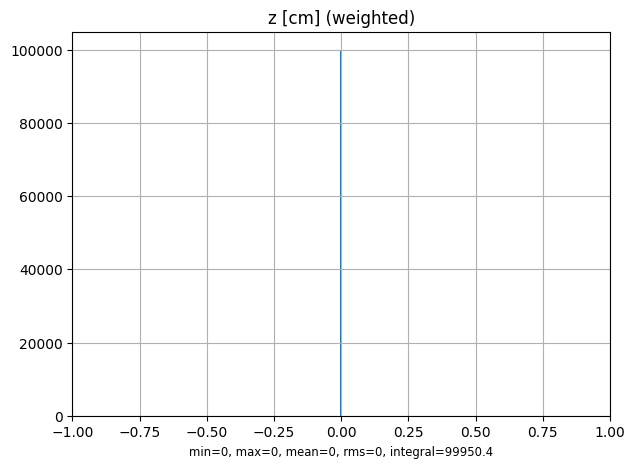

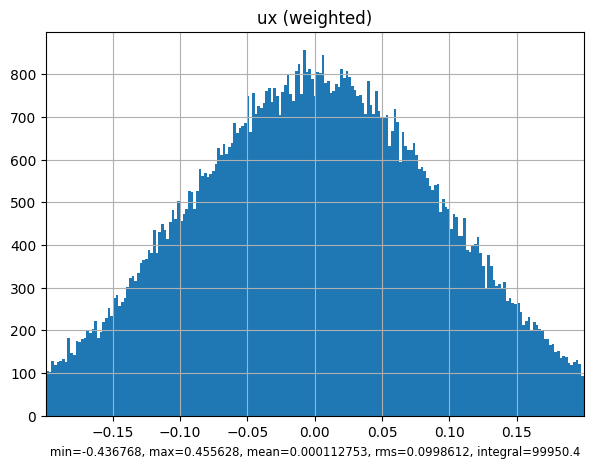

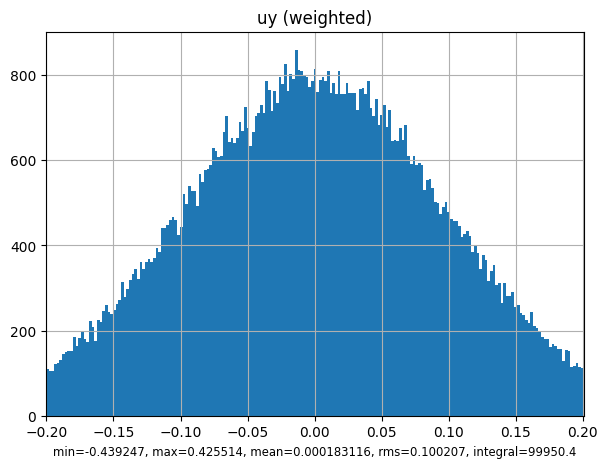

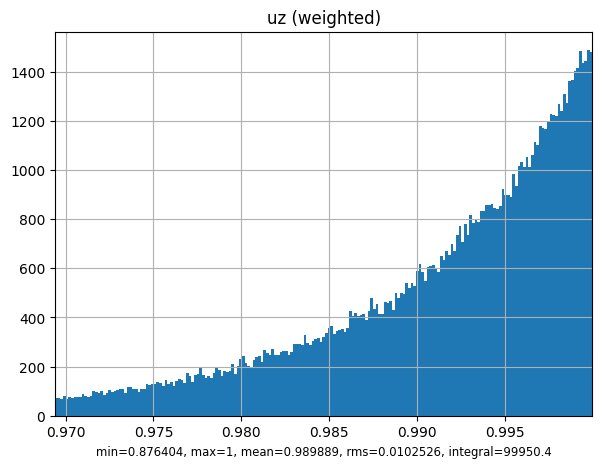

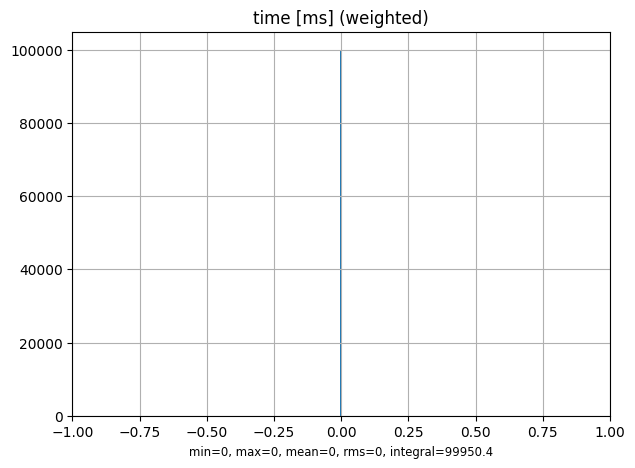

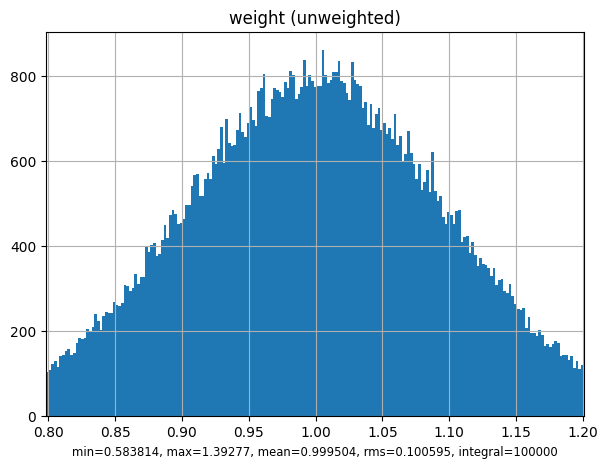

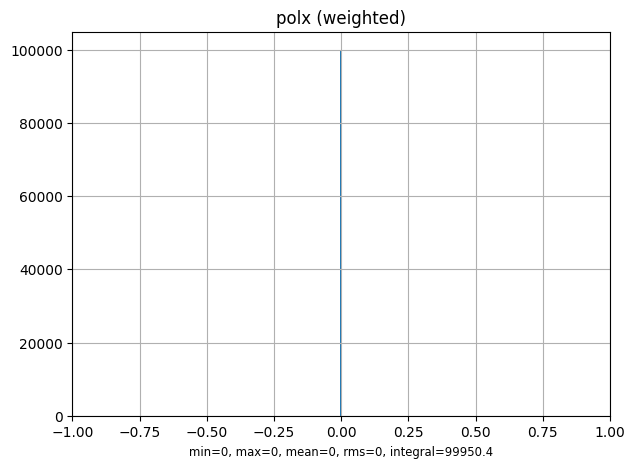

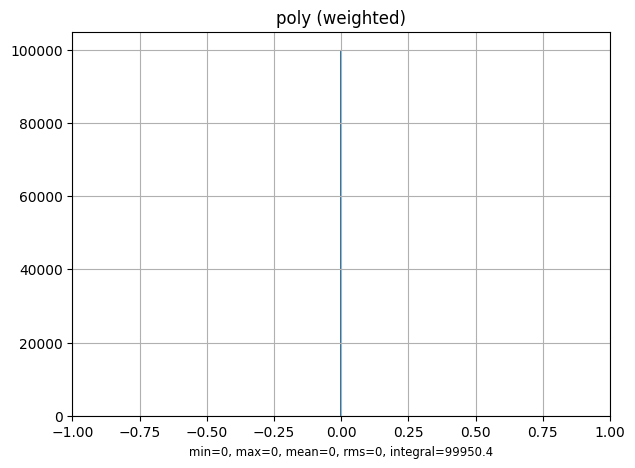

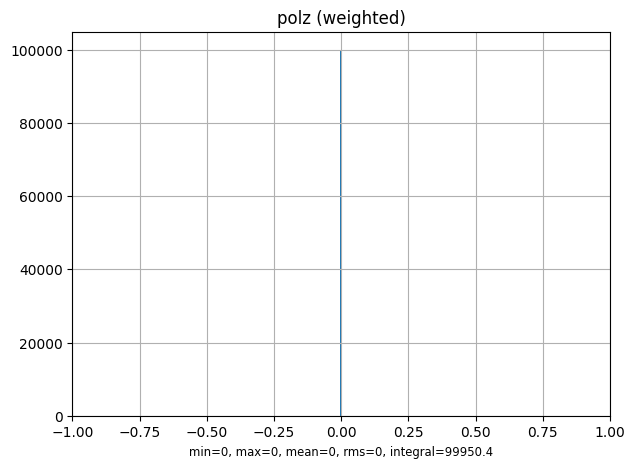

In [42]:
# Con MCPL

mcpl.dump_stats(mcpl.collect_stats(mcplfile))
mcpl.plot_stats(mcplfile)

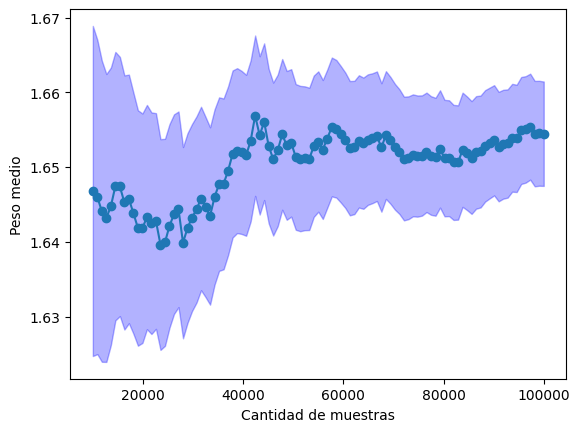

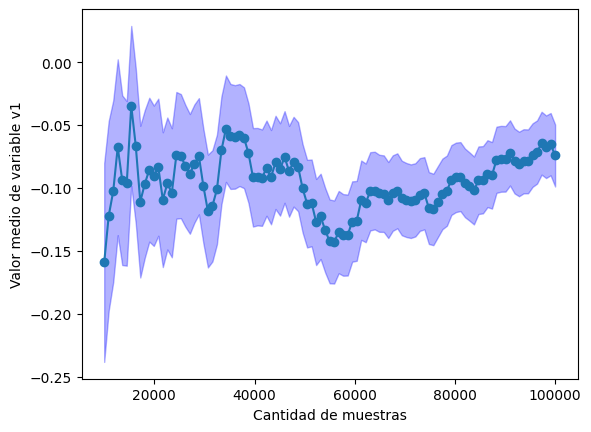

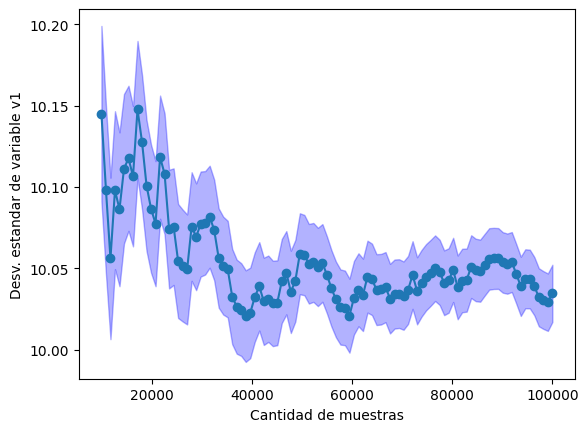

In [21]:
# Con ks.Stats

# Intervalos de variables (box)
dxymax = -1
dzmin = np.sqrt(1-dxymax**2)
maskfun = ks.Box([None,None,None,None,None,None,dzmin], None)

# Funcion de peso
fact_dosim = ks.H10(pt=plist.pt)
weightfun = lambda parts: parts[:,0]

parts,ws = plist.get()
stats = ks.Stats(parts, ws, weightfun=weightfun, maskfun=maskfun)

N,I,err = stats.mean_weight(steps=100)
plt.show()
N,mn,err = stats.mean(var=1, steps=100)
plt.show()
N,mn,err = stats.std(var=1, steps=100)
plt.show()

# Crear graficos

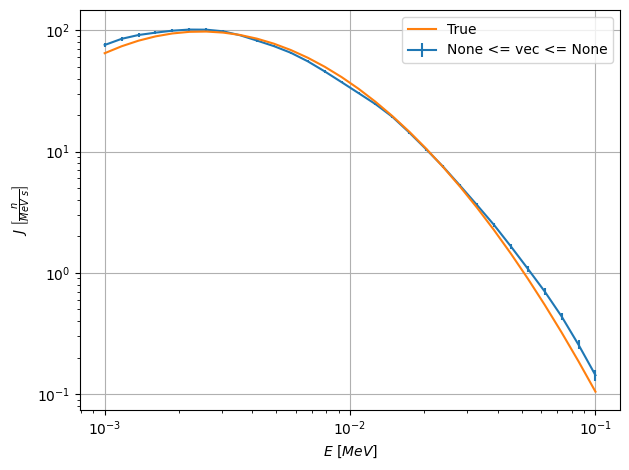

In [58]:
# Graficos en E

vec0 = None
vec1 = None
EE = np.logspace(-3,-1,30)
fig,scores = s.plot_E(EE, vec0, vec1)

uu = np.log(1/EE)
plt.plot(EE, 1/EE * np.exp(-(uu-5)**2/(2*su**2))/(su*np.sqrt(2*np.pi)), zorder=3, label="True")
plt.legend()

plt.tight_layout()
#plt.savefig("ekin.pdf")
plt.show()

Usando 1000 particulas para ajuste
Usando 10000 particulas para ajuste
Usando 100000 particulas para ajuste


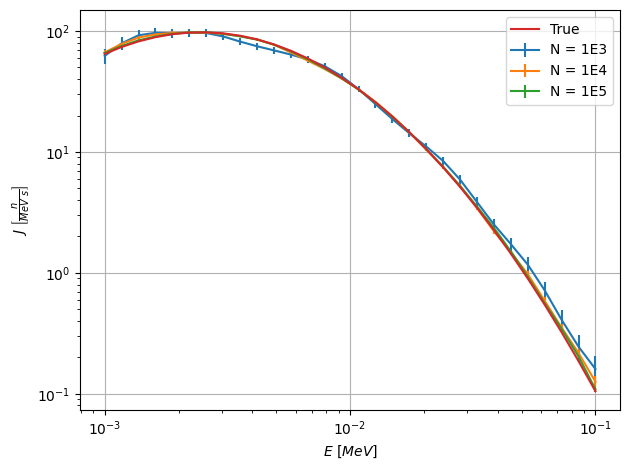

In [51]:
# Graficos en E

vec0 = None
vec1 = None
EE = np.logspace(-3,-1,30)

s.bw_method = None

s.fit(N=1E3)
fig,scores = s.plot_E(EE, vec0, vec1)

s.fit(N=1E4)
fig,scores = s.plot_E(EE, vec0, vec1)

s.fit(N=1E5)
fig,scores = s.plot_E(EE, vec0, vec1)

uu = np.log(1/EE)
plt.plot(EE, 1/EE * np.exp(-(uu-5)**2/(2*su**2))/(su*np.sqrt(2*np.pi)), zorder=3, label="True")

plt.legend()
L=fig.axes[0].legend()
L.get_texts()[1].set_text('N = 1E3')
L.get_texts()[2].set_text('N = 1E4')
L.get_texts()[3].set_text('N = 1E5')

plt.tight_layout()
plt.savefig("ekin.pdf")
plt.show()

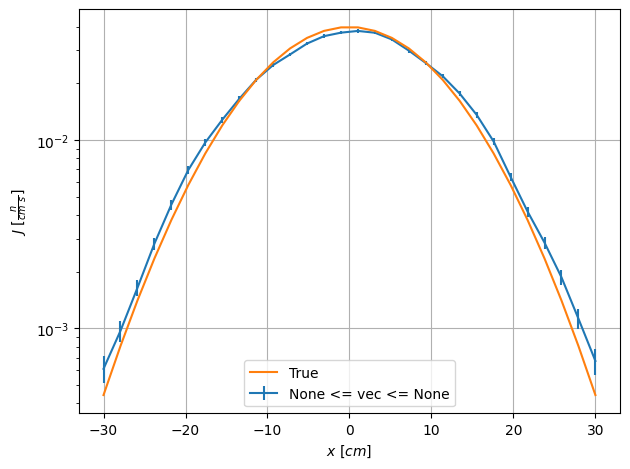

In [59]:
# Graficos en x

vec0 = None # [0, -30,-30, 0,-180]
vec1 = None # [25, 30,30, 1,180]
xx = np.linspace(-30,30,30)
fig,scores = s.plot_integr(xx, "x", vec0, vec1)

pdf = np.exp(-(xx/sx)**2/2)/(sx*np.sqrt(2*np.pi))
plt.plot(xx, pdf, zorder=5, label="True")
plt.legend()

plt.tight_layout()
plt.savefig("x.pdf")
plt.show()


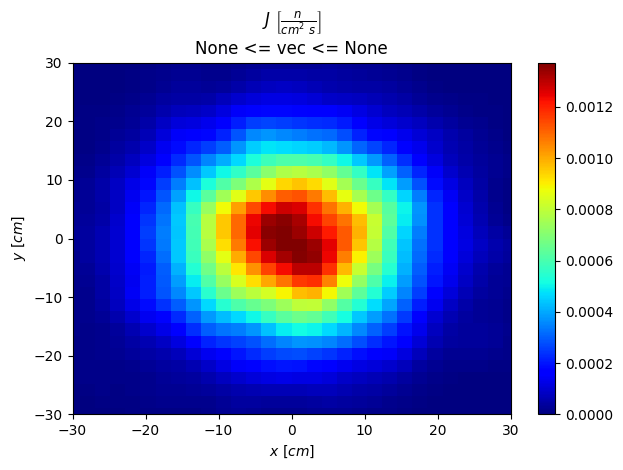

In [60]:
# Graficos en xy

vec0 = None # [0,  -30,-30, -1,-1,-1]
vec1 = None # [1, 30,30, 1,1,1]
xx = np.linspace(-30,30,30)
yy = np.linspace(-30,30,30)
fig,scores = s.plot2D_integr([xx,yy], ["x","y"], vec0, vec1)

plt.tight_layout()
plt.savefig("xy.pdf")
plt.show()


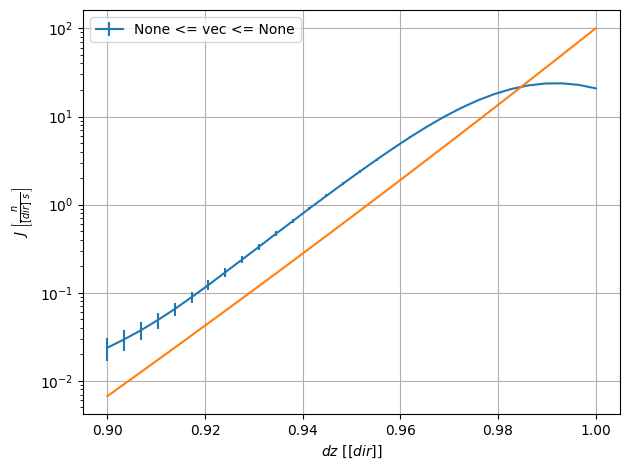

In [61]:
# Graficos en dz

vec0 = None # [20, -30,-30, 0,-180]
vec1 = None # [25, 30,30, 1,180]
ddz = np.linspace(0.9,1,30)
fig,[scores,errs] = s.plot_integr(ddz, "dz", vec0, vec1)

ddz = ddz[:30]
ddx = np.sqrt(1-ddz**2)
pdf = 2*np.pi*ddz * np.exp(-(ddx/sdx)**2/2)/(sdx*sdy*(2*np.pi))
plt.plot(ddz, pdf, zorder=5, label="True")

plt.tight_layout()
plt.show()


In [26]:
s.kde.bw

0.2368617007564736

In [27]:
s.kde.bw_method /= 3

Usando 1000 particulas para ajuste
Usando 10000 particulas para ajuste
Usando 100000 particulas para ajuste


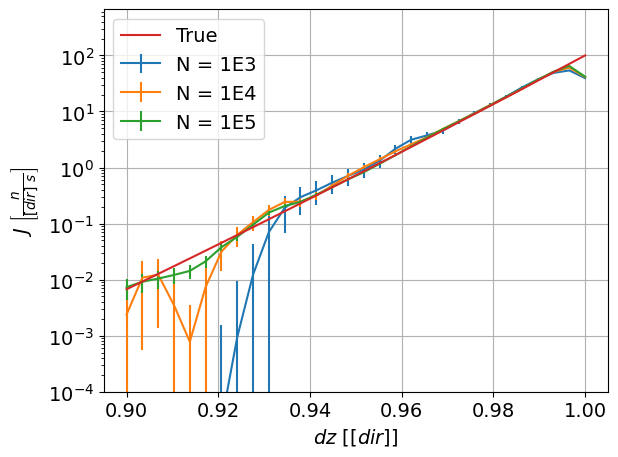

In [28]:
# Graficos en dz

vec0 = None # [20, -30,-30, 0,-180]
vec1 = None # [25, 30,30, 1,180]
ddz = np.linspace(0.9,1,30)

s.bw_method = None

s.fit(N=1E3)
fig,[scores,errs] = s.plot_integr(ddz, "dz", vec0, vec1)

s.fit(N=1E4)
fig,[scores,errs] = s.plot_integr(ddz, "dz", vec0, vec1)
plt.grid()

s.fit(N=1E5)
fig,[scores,errs] = s.plot_integr(ddz, "dz", vec0, vec1)
plt.grid()

ddz = ddz[:30]
ddx = np.sqrt(1-ddz**2)
pdf = 2*np.pi*ddz * np.exp(-(ddx/sdx)**2/2)/(sdx*sdy*(2*np.pi))
plt.plot(ddz, pdf, zorder=5, label="True")

L=plt.legend()
L.get_texts()[1].set_text('N = 1E3')
L.get_texts()[2].set_text('N = 1E4')
L.get_texts()[3].set_text('N = 1E5')


plt.ylim(bottom=1E-4)
plt.tight_layout()
plt.savefig("dz.pdf")
plt.show()


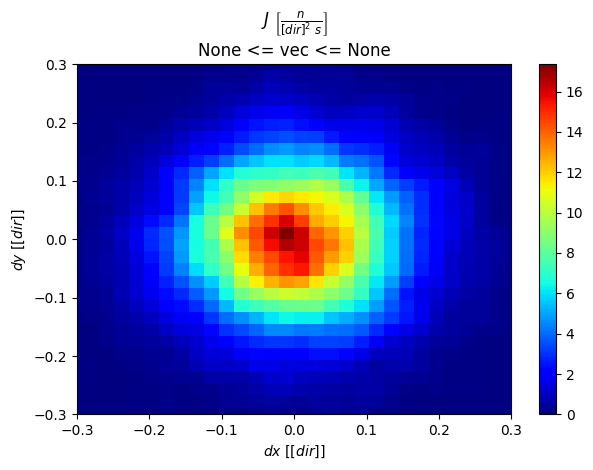

In [9]:
# Graficos en dxdy

vec0 = None # [0, -30,-30, 0,-180]
vec1 = None # [25, 30,30, 1,180]
xx = np.linspace(-.3,.3,30)
yy = np.linspace(-.3,.3,30)
fig,scores = s.plot2D_integr([xx,yy], ["dx","dy"], vec0, vec1)

plt.tight_layout()
plt.savefig("dxdy.pdf")
plt.show()


# Resamplear muestras

In [55]:
s.save()
!ksource resample "samples_source.xml" -o "resampled" -n 1E5
mcplfile = "resampled.mcpl.gz"

Archivo de definicion de fuente: samples_source.xml
Reading xmlfile samples_source.xml...
Resampleando...
MCPL: Attempting to compress file resampled.mcpl with gzip
MCPL: Succesfully compressed file into resampled.mcpl.gz
Resampleo exitoso


### Vuelva al inicio para analizar distribucion de muestras resampleadas